In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('repeated_letters_words_v9.csv')
df = df.sample(frac = 1)

pipeline = Pipeline([
    ('hashing', HashingVectorizer(analyzer='char')),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

parameters = {
    'tfidf__use_idf': [(True, True), (False, False), (True, False), (False, True)],
    'clf': [MultinomialNB(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), KNeighborsClassifier()],
}

X_train, X_test, y_train, y_test = train_test_split(df['emphasized'], df['actual'], test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


print("Best Model:", best_model)
print("Best Parameters:", best_params)

# use the best model to predict the actual words for the test data
y_pred = best_model.predict(X_test)

# print the classification report, confusion matrix, and accuracy score
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

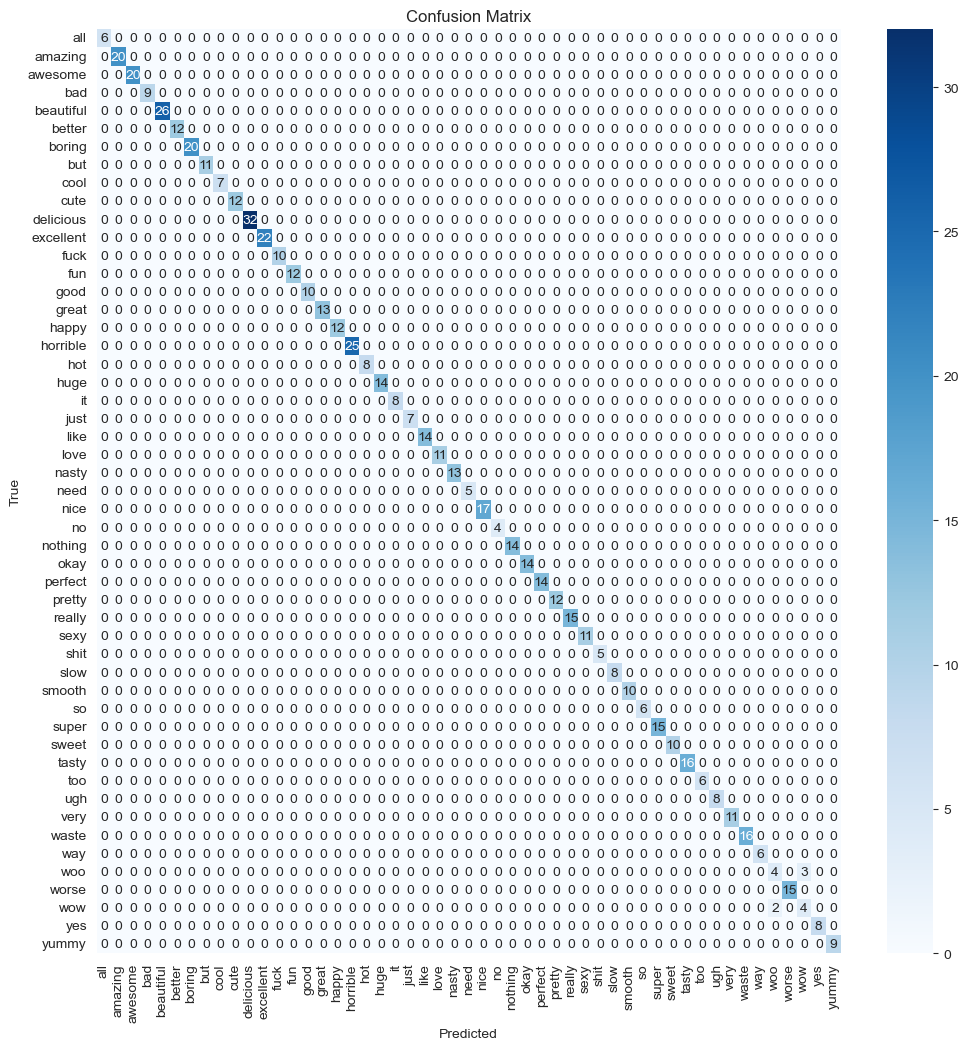

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))

labels = np.unique(df['actual'])

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

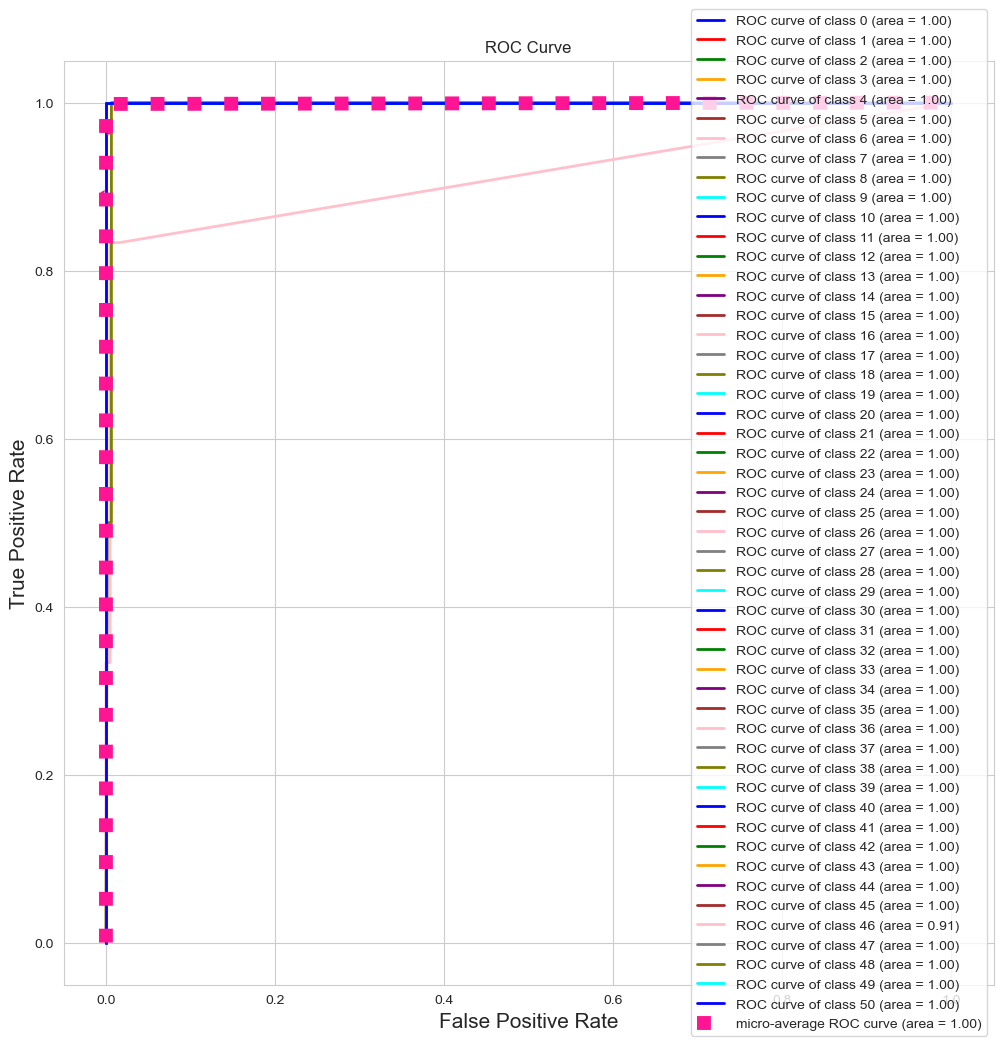

In [38]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Get the predicted probabilities for each class
y_score = best_model.predict_proba(X_test)

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(12,12))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=10)

# Add labels and legend
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('ROC Curve')
plt.legend(loc="right")
plt.show()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U5')) -> None

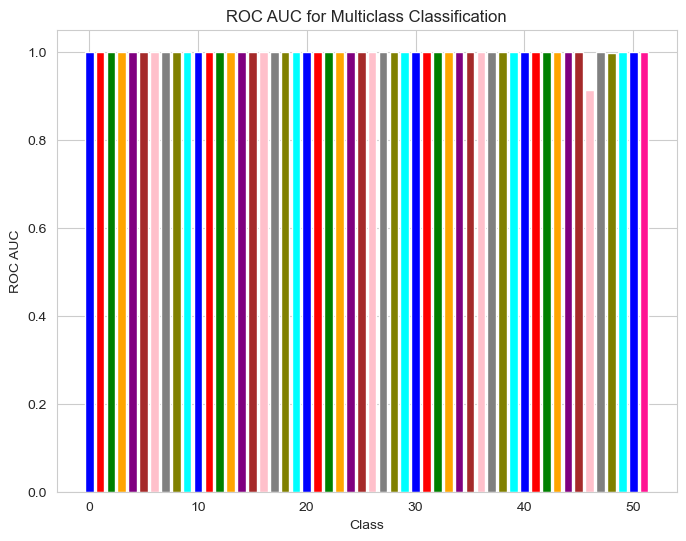

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Get the predicted probabilities for each class
y_score = best_model.predict_proba(X_test)

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC AUC for each class
n_classes = y_test_bin.shape[1]
roc_auc = dict()
for i in range(n_classes):
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Compute micro-average ROC AUC
roc_auc["micro"] = roc_auc_score(y_test_bin, y_score, average="micro")

# Plot ROC AUC for each class
plt.figure(figsize=(8,6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.bar(i, roc_auc[i], color=color, align='center',
            label='ROC AUC of class {0} (AUC = {1:0.2f})'
            ''.format(i, roc_auc[i]))

# Plot micro-average ROC AUC
plt.bar(n_classes, roc_auc["micro"], color='deeppink', align='center',
        label='micro-average ROC AUC (AUC = {0:0.2f})'
        ''.format(roc_auc["micro"]))

# Add labels and legend
plt.xlabel('Class')
plt.ylabel('ROC AUC')
plt.title('ROC AUC for Multiclass Classification')
plt.xticks(range(n_classes+1), np.arange(n_classes).astype(str) + ['micro'])
plt.legend(loc="lower right")
plt.show()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# calculate the ROC AUC score and plot the curve
y_prob = best_model.decision_function(X_test)
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y_train))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))
colors = ['blue', 'red', 'green', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,label='ROC curve of class {0} (area = {1:0.2f})'''.format(best_model.classes_[i], roc_auc[i]))

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVCn", size=16);